## Generalized Linear Models
### Paul Anzel 11/23/2015

If we were going to do a fit to data, we generally think of our data following some form like

$$ y = \bar X \bar \beta + \epsilon $$

where $\bar X = (1, x_1, x_2, ..., x_n)$ and $\bar \beta = (\beta_0, \beta_1, ..., \beta_n)^T$ and $\epsilon$ is some sort of error term that would be normally distributed (Central Limit Theorem on all the things we don't really have in our model). You might be creating terms like $x_4 = x_2^2$ to provide some sort of nonlinear model, but overall we can take our data and stick it in some nice Ordinary Least-Squares (OLS) solver to fit this.

However, what do we do if we expect our error term *not* to be Gaussian? When I'm trying to do demand modeling for low velocity products, the Gaussian error is not an accurate model--only a few items get sold (so we see the discreteness play a role) and we don't have negative items getting sold, so there's a hard limit that $D \geq 0$.

Instead, I might assume that some large (fixed) number of people $n$ look at the product, but there's some small probability $\mu$ that buy the item. In that case, the expected sales at a price would then be governed by

$$p(k| \lambda = (\mu n)) = \frac{\lambda^k}{k!}e^{-\lambda}$$

and then we need to model $\mu$ in some fashion, perhaps similarly assuming that $\mu = \frac{1}{n} \bar X \bar \beta$.

However, just plugging our data into an ordinary least-squares model won't quite do it, since the least-squares error minimization doesn't properly take into account the necessary distribution of data. So, in order to deal with this, we need to use a different technique to fit the data.

In [1]:
import numpy as np

from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import numpy.random as rd
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [14]:
rd.seed(2678)

ex_prices = np.array([2, 3, 4, 5, 6])
N = 10

fit_a = 0.5
fit_b = -.05

sales_data = np.array([])
price_data = np.array([])

for price in ex_prices:
    sales_at_price = stats.poisson(fit_a + fit_b*price).rvs(N)
    sales_data = np.concatenate([sales_data, sales_at_price])
    price_data = np.concatenate([price_data, price*np.ones(N)])
    
sales_info = pd.DataFrame({'price': price_data, 'sales': sales_data})

In [15]:
price_range = np.linspace(ex_prices.min()-0.5, ex_prices.max()+0.5)
true_demand = fit_a + price_range*fit_b
linearfitter = LinearRegression(fit_intercept=True)
linearfitter.fit(price_data[:, np.newaxis], sales_data)
lin_demand = linearfitter.predict(price_range[:, np.newaxis])

size_factor = 70
listcounts = sales_info.groupby(['price', 'sales']).size()
sss_price = []
sss_qty = []
sss_count = []
for val in listcounts.index.values:
    price, qty = val
    sss_price.append(price)
    sss_qty.append(qty)
for countin in listcounts:
    sss_count.append(countin)
sss_price=np.array(sss_price)
sss_qty=np.array(sss_qty)
sss_count=size_factor*np.array(sss_count)

In [16]:
print('OLS slope = %.3f' % linearfitter.coef_)

OLS slope = -0.120


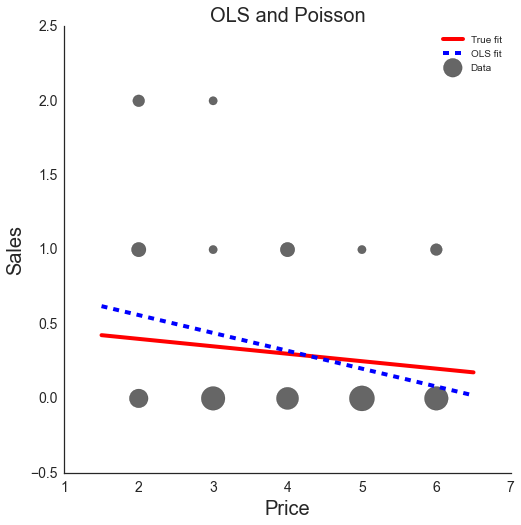

In [17]:
plt.figure(figsize=(8,8))
plt.scatter(sss_price, sss_qty, s=sss_count, color='k', alpha=0.6, label='Data')
plt.plot(price_range, true_demand, color='r', linewidth=4, label='True fit')
plt.plot(price_range, lin_demand, color='b', linewidth=4, linestyle='--', label='OLS fit')
plt.xlabel('Price', fontsize=20)
plt.ylabel('Sales', fontsize=20)
plt.legend()
plt.tick_params(labelsize=14)
plt.title('OLS and Poisson', fontsize=20)
sns.despine()

(It's worth noting that I wasn't able to get a really noticeable difference between the True and OLS fit until I had the fit very close to zero. So keep that in mind.)

This leads to the idea of using Generalized Linear Models (GLMs). Basically, assume you can define your values to follow some data distribution around $E(\bar X) = \mu$. We don't necessarily expect $\mu$ to be linear in $\bar X$, but we do expect some form

$$ \mu = f(\bar X \bar \beta)$$

### Ingredients for a GLM

A GLM has three main elements:
1. Some values $\bar X$ that we expect to govern our function in some form based on $\bar X \bar \beta$ (this is almost tautological, but everyone else likes to point this out so...)
2. Some governing distribution of data of $y$ around some fixed $\bar X$.

   This distribution is usually in the exponential family, which have some form $f(x | \theta) = h(x) \exp(\eta(\theta) T(x) - A(\theta))$. Fortunately, many common distributions--Gaussian, Poisson, Negative Binomial, etc. fit this sort of model (a table can be seen [here](https://en.wikipedia.org/wiki/Exponential_family#Table_of_distributions)).
   
   You can use non-exponential family distributions, like the Cauchy distribution. But the math may be harder, and there are some limits on non-exponential distributions, described on the second reference at the end.

3. Some function f (generally we use $g^{-1}$) that connects $\mu$ and $\bar X \bar \beta$. 

   This is called a link function...

### Link functions

This gives the overall shape of how we expect our regression curve to fit. As far as I can tell (but don't quote me on this) you can use any link function as long as it satisfies:
- The link function must be invertible (one-to-one).
- the link function's range should cover the expected domain for the data (e.g. if you're going to get negative data values, don't use a logarithmic link).
- The link function should be continuous.

#### Some common link functions

- Identity $g = \text{id}(x)$, $\mu = \bar X \bar \beta$
- Logarithm $g = \ln(x)$, $\mu = \exp(\bar X \bar \beta)$
- Power $g = x^p$, $\mu = (\bar X \bar \beta)^{1/p}$
- Logit $g = \ln(\frac{x}{1-x})$, $\mu = \frac{1}{1-\exp(-\bar X \bar \beta)}$
- Probit $g = \text{probit}(x)$, $\mu = \frac{1}{2}\text{erfc}(-\bar X \bar \beta /\sqrt{2})$. This is very close to Logit, and the Probit basically is the inverse of the Gaussian CDF. Don't ask me when you use one or the other...

### Canonical link function

Each data distribution has a most "natural" link function, which we call the canonical link function. There's some description [here](https://stats.stackexchange.com/questions/40876/difference-between-link-function-and-canonical-link-function-for-glm) but it's not that important for our purposes.

Canonical link functions have some nice properties, among them:

1. The statistic $X'y$ will be *sufficient* (everything needed to describe the sample).
2. Newton's method and Fisher scoring for finding the ML estimator coincide.
3. The sum of residuals will equal 0.

However, it is not necessary to use them.

### Probability distributions and likelihood functions

When we think about the probability of some data, we say "we have some parameters $\theta$ (perhaps we're saying $\theta = \bar \beta$), what's the chance we get data point $y$". This is the standard $P(y | \theta)$. Thinking about the likelihood is kind of the opposite--we got a data point $y$, what's the chance of $\theta$?

Fortunately, our likelihood function is pretty easy to get to

$$\mathcal{L}(\theta|y) = P(y|\theta)$$

And if you have a whole bunch of observations

$$\mathcal{L}(\theta|\bar y) = \prod_i P(y_i | \theta)$$

So basically, we switch what we think are the variables and what are the parameters.

When we try and fit a model to the data, we ask "what would be the most likely fit". Looking at the graph below, you *could* get our data from the dotted line, but that would require dozens of data points to all be drawn lower than it and this seems like a pretty unusual situation. The other line would be a better guess.

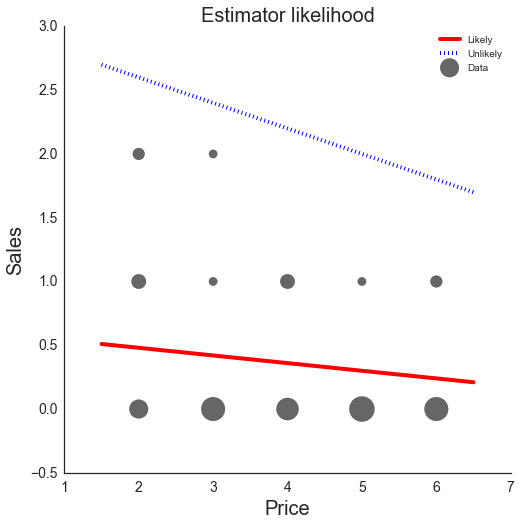

In [18]:
likely = 0.6 - 0.06*price_range
unlikely = 3 - 0.2*price_range

plt.figure(figsize=(8,8))
plt.scatter(sss_price, sss_qty, s=sss_count, color='k', alpha=0.6, label='Data')
plt.plot(price_range, likely, color='r', linewidth=4, label='Likely')
plt.plot(price_range, unlikely, color='b', linewidth=4, linestyle=':', label='Unlikely')
plt.xlabel('Price', fontsize=20)
plt.ylabel('Sales', fontsize=20)
plt.legend()
plt.tick_params(labelsize=14)
plt.title('Estimator likelihood', fontsize=20)
sns.despine()

This leads to the idea of finding the Maximum Likelihood Estimator (MLE)--we try to estimate our parameters $\theta$ by trying to maximize $\mathcal{L}$ based on our data.

One problem--we know how to minimize/maximize something (take a derivative and set to zero, or take a derivative to get a gradient function and follow the gradient's path) but this is kind of difficult to do with a product, as $(fgh)' = f'gh + fg'h + fgh'$.

There is, however, an easy and strictly monotonic function that lets us maximize $\mathcal{L}$ while converting to a sum, leading us to...

### Log-likelihood

Since $\log (\prod f_i) = \sum (\log f_i)$, just take a (natural) logarithm. Let us define $L = \log \mathcal{L}$.

And since we're (usually) working with the exponential family of distributions, this is even nicer as the logarithm and exponent cancel each other out.

Here's some common results:
- Normal/Gaussian: $L = - \frac{1}{2}\sum (y - \mu)^2/\sigma^2$
- Poisson: $L = - \left( \sum y \ln (y/\mu) - \sum (y - \mu) \right)$
- Binomial: $L = - \left( \sum y \ln (y/\mu) - \sum (n - y)  \ln \left( (n - y)(n - \mu)\right) \right)$
- Gamma: $L = p\left(\sum \ln (y/\mu) - \sum(y - \mu)/\mu \right)$

Note the similarity of the Normal log-likelihood to Ordinary Least Squares. Plus, there's a clear extension of this for trying to deal with heteroskedastic data.

From a machine-learning perspective, we could think that our choice of statistical distribution affects our "error-to-minimize" term $J = -2L$. For example, for standard OLS you get $J = \sum_i (y_i - \hat y_i)^2$ (we've ignored the $\sigma$ term, as it's just for proportionality), whereas the other versions get their own error terms (sometimes called the *deviance*, but apparently this is [somewhat wrong](https://en.wikipedia.org/wiki/Deviance_(statistics%29)).

### McFadden's $R^2$

This leads to one more generalized form of $R^2$ scoring. Regular $R^2$ has the form:

$$R^2 = 1 - \frac{\text{Squared error to model}}{\text{Squared error to average y}} = 1 - \frac{\sum (y - \hat y)^2}{\sum (y - mean(y))^2}$$

So, instead of using squared error, use the deviances instead.

$$R^2 = 1 - \frac{\text{Log-Likelihood Error to model}}{\text{Log-Likelihood Error to average y}} = 1 - \frac{L_{model}}{L_{mean}} = 1 - \frac{J_{model}}{J_{mean}} = 1 - \frac{\ln \mathcal{L}_{model}}{\ln \mathcal{L}_{mean}} $$

This is McFadden's $R^2$. For homoskedastic Gaussian error it's the same as standard OLS $R^2$. Some further refinements of McFadden's $R^2$ are available in one of the references below.

### Solving this

See [Wikipedia](https://en.wikipedia.org/wiki/Generalized_linear_model#Fitting). You're generally using the Newton-Raphson method with either the inverse observed information matrix or with the inverse Fisher information matrix. Unless you're trying to implement this on your own, I wouldn't worry about this too much.

### Doing this in Python
Fortunately, we can avoid dealing with implementing the algorithm ourselves (in some of the more usual cases, at least). For this we use the [statsmodels](http://statsmodels.sourceforge.net/stable/glm.html) package.

N.B. Scikit-Learn has some packages labelled Generalized-Linear-Models, but these don't do what we need, they're more just OLS type fitters.

In [23]:
# This gives general aceess to everything in statsmodels
import statsmodels.api as sm
# Statsmodels.genmod.families.links gives up the links
from statsmodels.genmod.families.links import identity as smidentity

X_val = sm.add_constant(price_data)
glm_poisson = sm.GLM(sales_data, X_val, family=sm.families.Poisson())
glm_results = glm_poisson.fit()
print(glm_results.summary())
beta = glm_results.params
print('LL-Poisson coef: %.3f' % beta[1])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   50
Model:                            GLM   Df Residuals:                       48
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -33.987
Date:                Mon, 23 Nov 2015   Deviance:                       40.133
Time:                        14:42:06   Pearson chi2:                     46.9
No. Iterations:                     8                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.3071      0.682      0.450      0.652        -1.029     1.643
x1            -0.4004      0.195     -2.052      0.0

In [24]:
llp_demand = np.exp(beta[0] + beta[1]*price_range)

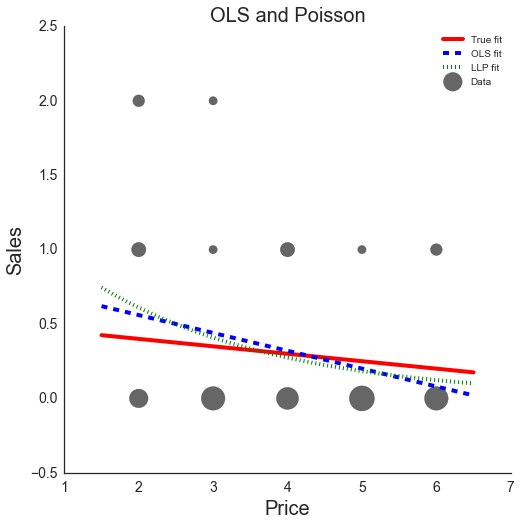

In [25]:
plt.figure(figsize=(8,8))
plt.scatter(sss_price, sss_qty, s=sss_count, color='k', alpha=0.6, label='Data')
plt.plot(price_range, true_demand, color='r', linewidth=4, label='True fit')
plt.plot(price_range, lin_demand, color='b', linewidth=4, linestyle='--', label='OLS fit')
plt.plot(price_range, llp_demand, color='g', linewidth=4, linestyle=':', label='LLP fit')
plt.xlabel('Price', fontsize=20)
plt.ylabel('Sales', fontsize=20)
plt.legend()
plt.tick_params(labelsize=14)
plt.title('OLS and Poisson', fontsize=20)
sns.despine()

In [22]:
lf_b = linearfitter.coef_
lf_a = linearfitter.intercept_

print('Ideal price for revenue, True: $%.2f' % (-fit_a/(2.0*fit_b)))
print('Ideal price for revenue, OLS: $%.2f' % (-lf_a/(2.0*lf_b)))
print('Ideal price for revenue, Poisson-LL: $%.2f' % (-beta[0]/(2.0*beta[1])))

Ideal price for revenue, True: $5.00
Ideal price for revenue, OLS: $3.33
Ideal price for revenue, Poisson-LL: $3.70


The Linear Link Poisson is doing a little better than OLS, though if you try with higher $N$ this effect does start to go away.

References:
- [Original paper describing GLMs](https://www.jstor.org/stable/2344614?seq=1#page_scan_tab_contents) Paywall :( I'll put the PDF on our drive.
- [Consistency and Asymptotic Normality of the Maximum Likelihood Estimator in Generalized Linear Models](http://projecteuclid.org/download/pdf_1/euclid.aos/1176346597)
- [Alternative $R^2$](http://www.ats.ucla.edu/stat/mult_pkg/faq/general/Psuedo_RSquareds.htm)

This has been a lot of text, and I am sorry.